In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import model_selection
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.preprocessing import OrdinalEncoder

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'test.csv']


In [41]:
dfr = pd.read_csv("../input/train.csv")
dfe = pd.read_csv("../input/test.csv")
pred_x1 = dfe['User_ID']
pred_x2 = dfe['Product_ID']

In [42]:
#check how much data we have
print("training data shape is " + str(dfr.shape) +" ,where as test data shape is "+str(dfe.shape))

training data shape is (550068, 12) ,where as test data shape is (233599, 11)


In [43]:
#check data types
dfr.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                        int64
dtype: object

Other than purchase column, other information is categorical information providing purchase details.
One thing to note, product category 1 is int, where as product category 2,3 are showing in float. This is possible due to null. Lets check for uniqueness in data for Customer and Products.

In [44]:
unique_user = len(set(dfe.User_ID.unique()).intersection(set(dfr.User_ID.unique())))/len(set(dfr.User_ID.unique()))
print("% of Unique customers in train dataset which are present in test {}%".format(round(unique_user * 100, 2)))

unique_prod = len(set(dfe.Product_ID.unique()).intersection(set(dfr.Product_ID.unique())))/len(set(dfr.Product_ID.unique()))
print("% of Unique products in train dataset which are present in test {}%".format(round(unique_prod * 100, 2)))

% of Unique customers in train dataset which are present in test 100.0%
% of Unique products in train dataset which are present in test 94.88%


There are exactly same users/buyers in train and test set, where as there as ~6% products in train set which are not in test set. There are 5891 unique buyers in both. 3631 unique products in train and 3491 in test data.

Focusing on preprocessing, lets start with null checks.

In [45]:
dfr.isna().sum()
dfe.isna().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2             72344
Product_Category_3            162562
dtype: int64

As suspected there are nulls present in category 2 and 3 in both train and test. 
Since the counts is high, we can't remove the rows with null. Lets take a look at actual data to understand how we can fix null issue.

In [46]:
dfr.head()
dfr.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


A quick look at data ranges reveals that there are 20 distinct product categories. From data description we know that the product category 2 and 3 are the possible categories for the product given. Hence we can assume that the rows where we have nulls in cat 2 and 3, product category is correctly identified and equals category 1. Hence lets fill these rows with category 1 values. 

In [47]:
dfr.loc[pd.isnull(dfr['Product_Category_2']),'Product_Category_2']=dfr['Product_Category_1']
dfr.loc[pd.isnull(dfr['Product_Category_3']),'Product_Category_3']=dfr['Product_Category_1']
dfe.loc[pd.isnull(dfe['Product_Category_2']),'Product_Category_2']=dfe['Product_Category_1']
dfe.loc[pd.isnull(dfe['Product_Category_3']),'Product_Category_3']=dfe['Product_Category_1']

Update columns types to int for reducing size and more efficiency.

In [48]:
dfr['Product_Category_2'] = dfr['Product_Category_2'].astype(int)
dfr['Product_Category_3'] = dfr['Product_Category_3'].astype(int)
dfe['Product_Category_2'] = dfe['Product_Category_2'].astype(int)
dfe['Product_Category_3'] = dfe['Product_Category_3'].astype(int)

Here User_ID despite being categorical feature, is getting read as numerical. In order to avoid false effect of big ID values, lets convert it to str and then use OneHotEncoder to encode all columns.

In [49]:
dfr['User_ID']=dfr['User_ID'].astype(str)
dfe['User_ID']=dfe['User_ID'].astype(str)

In [50]:
#We will use pandas .codes for ordinal encoding
for feature in dfr.columns: # Loop through all columns in the dataframe
    if dfr[feature].dtype == 'object': # Only apply for columns with categorical strings
        dfr[feature] = pd.Categorical(dfr[feature]).codes # Replace strings with an integer
for feature in dfe.columns: # Loop through all columns in the dataframe
    if dfe[feature].dtype == 'object': # Only apply for columns with categorical strings
        dfe[feature] = pd.Categorical(dfe[feature]).codes # Replace strings with an integer

In [51]:
dfe.dtypes

User_ID                       int16
Product_ID                    int16
Gender                         int8
Age                            int8
Occupation                    int64
City_Category                  int8
Stay_In_Current_City_Years     int8
Marital_Status                int64
Product_Category_1            int64
Product_Category_2            int64
Product_Category_3            int64
dtype: object

Beginning some feature creation to increase accuracy.

In [52]:
print("beginning Aggregate measure creation - ")
#Single level Aggregate Features

col_list = dfe.columns
for col_name in col_list:
    group = dfr.groupby([col_name]).agg({'Purchase': ['mean']})
    group.columns = [ col_name.lower()+'_avg_spend']
    dfr = pd.merge(dfr, group, on=[col_name], how='left')
    dfe = pd.merge(dfe, group, on=[col_name], how='left')


    group = dfr.groupby([col_name]).agg({'Purchase': ['max']})
    group.columns = [ col_name.lower()+'_max_spend']
    dfr = pd.merge(dfr, group, on=[col_name], how='left')
    dfe = pd.merge(dfe, group, on=[col_name], how='left')
    
    group = dfr.groupby([col_name]).agg({'Purchase': ['min']})
    group.columns = [ col_name.lower()+'_min_spend']
    dfr = pd.merge(dfr, group, on=[col_name], how='left')
    dfe = pd.merge(dfe, group, on=[col_name], how='left')

#Additional Multi level Aggregate Features


#Aggregate features by user's spend per product, product categories
group = dfr.groupby(['User_ID','Product_ID']).agg({'Purchase': ['mean']})
group.columns = [ 'user_prod_avg_spend']
dfr = pd.merge(dfr, group, on=['User_ID','Product_ID'], how='left')
dfe = pd.merge(dfe, group, on=['User_ID','Product_ID'], how='left')

group = dfr.groupby(['User_ID']).agg({'Purchase': ['mean']})
group.columns = [ 'user_avg_spend']
dfr = pd.merge(dfr, group, on=['User_ID'], how='left')
dfe = pd.merge(dfe, group, on=['User_ID'], how='left')

group = dfr.groupby(['Product_ID']).agg({'Purchase': ['mean']})
group.columns = [ 'prod_avg_spend']
dfr = pd.merge(dfr, group, on=['Product_ID'], how='left')
dfe = pd.merge(dfe, group, on=['Product_ID'], how='left')

dfr.loc[pd.isnull(dfr['user_prod_avg_spend']),'user_prod_avg_spend']=(dfr['user_avg_spend']+dfr['prod_avg_spend'])/2
dfe.loc[pd.isnull(dfe['user_prod_avg_spend']),'user_prod_avg_spend']=(dfe['user_avg_spend']+dfe['prod_avg_spend'])/2

group = dfr.groupby(['User_ID','Product_ID']).agg({'Purchase': ['max']})
group.columns = [ 'user_prod_max_spend']
dfr = pd.merge(dfr, group, on=['User_ID','Product_ID'], how='left')
dfe = pd.merge(dfe, group, on=['User_ID','Product_ID'], how='left')

group = dfr.groupby(['User_ID','Product_ID']).agg({'Purchase': ['min']})
group.columns = [ 'user_prod_min_spend']
dfr = pd.merge(dfr, group, on=['User_ID','Product_ID'], how='left')
dfe = pd.merge(dfe, group, on=['User_ID','Product_ID'], how='left')


group = dfr.groupby(['User_ID','Product_Category_1']).agg({'Purchase': ['mean']})
group.columns = [ 'user_prod1_avg_spend']
dfr = pd.merge(dfr, group, on=['User_ID','Product_Category_1'], how='left')
dfe = pd.merge(dfe, group, on=['User_ID','Product_Category_1'], how='left')

group = dfr.groupby(['User_ID','Product_Category_1']).agg({'Purchase': ['max']})
group.columns = [ 'user_prod1_max_spend']
dfr = pd.merge(dfr, group, on=['User_ID','Product_Category_1'], how='left')
dfe = pd.merge(dfe, group, on=['User_ID','Product_Category_1'], how='left')

group = dfr.groupby(['User_ID','Product_Category_1']).agg({'Purchase': ['min']})
group.columns = [ 'user_prod1_min_spend']
dfr = pd.merge(dfr, group, on=['User_ID','Product_Category_1'], how='left')
dfe = pd.merge(dfe, group, on=['User_ID','Product_Category_1'], how='left')


#Aggregate features by user's spend per product, product categories
group = dfr.groupby(['User_ID','Product_Category_2']).agg({'Purchase': ['mean']})
group.columns = [ 'user_prod2_avg_spend']
dfr = pd.merge(dfr, group, on=['User_ID','Product_Category_2'], how='left')
dfe = pd.merge(dfe, group, on=['User_ID','Product_Category_2'], how='left')

group = dfr.groupby(['User_ID','Product_Category_2']).agg({'Purchase': ['max']})
group.columns = [ 'user_prod2_max_spend']
dfr = pd.merge(dfr, group, on=['User_ID','Product_Category_2'], how='left')
dfe = pd.merge(dfe, group, on=['User_ID','Product_Category_2'], how='left')

group = dfr.groupby(['User_ID','Product_Category_2']).agg({'Purchase': ['min']})
group.columns = [ 'user_prod2_min_spend']
dfr = pd.merge(dfr, group, on=['User_ID','Product_Category_2'], how='left')
dfe = pd.merge(dfe, group, on=['User_ID','Product_Category_2'], how='left')


group = dfr.groupby(['User_ID','Product_Category_3']).agg({'Purchase': ['mean']})
group.columns = [ 'user_prod3_avg_spend']
dfr = pd.merge(dfr, group, on=['User_ID','Product_Category_3'], how='left')
dfe = pd.merge(dfe, group, on=['User_ID','Product_Category_3'], how='left')

group = dfr.groupby(['User_ID','Product_Category_3']).agg({'Purchase': ['max']})
group.columns = [ 'user_prod3_max_spend']
dfr = pd.merge(dfr, group, on=['User_ID','Product_Category_3'], how='left')
dfe = pd.merge(dfe, group, on=['User_ID','Product_Category_3'], how='left')

group = dfr.groupby(['User_ID','Product_Category_3']).agg({'Purchase': ['min']})
group.columns = [ 'user_prod3_min_spend']
dfr = pd.merge(dfr, group, on=['User_ID','Product_Category_3'], how='left')
dfe = pd.merge(dfe, group, on=['User_ID','Product_Category_3'], how='left')

dfr['agg_product_category_avg_spend']=(dfr['product_category_1_avg_spend']+dfr['product_category_2_avg_spend']+dfr['product_category_3_avg_spend'])/3
dfr['agg_product_category_max_spend']=(dfr['product_category_1_max_spend']+dfr['product_category_2_max_spend']+dfr['product_category_3_max_spend'])/3
dfr['agg_product_category_min_spend']=(dfr['product_category_1_min_spend']+dfr['product_category_2_min_spend']+dfr['product_category_3_min_spend'])/3
dfe['agg_product_category_avg_spend']=(dfe['product_category_1_avg_spend']+dfe['product_category_2_avg_spend']+dfe['product_category_3_avg_spend'])/3
dfe['agg_product_category_max_spend']=(dfe['product_category_1_max_spend']+dfe['product_category_2_max_spend']+dfe['product_category_3_max_spend'])/3
dfe['agg_product_category_min_spend']=(dfe['product_category_1_min_spend']+dfe['product_category_2_min_spend']+dfe['product_category_3_min_spend'])/3


print("Completed Aggregate measure creation - ")

beginning Aggregate measure creation - 
Completed Aggregate measure creation - 


In [53]:
#split dependent variables
train_y = dfr['Purchase']
train_x = dfr.drop(columns=['Purchase'])
train_x.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,user_id_avg_spend,user_id_max_spend,user_id_min_spend,product_id_avg_spend,product_id_max_spend,product_id_min_spend,gender_avg_spend,gender_max_spend,gender_min_spend,age_avg_spend,age_max_spend,age_min_spend,occupation_avg_spend,occupation_max_spend,occupation_min_spend,city_category_avg_spend,city_category_max_spend,city_category_min_spend,stay_in_current_city_years_avg_spend,stay_in_current_city_years_max_spend,stay_in_current_city_years_min_spend,marital_status_avg_spend,marital_status_max_spend,marital_status_min_spend,product_category_1_avg_spend,product_category_1_max_spend,product_category_1_min_spend,product_category_2_avg_spend,product_category_2_max_spend,product_category_2_min_spend,product_category_3_avg_spend,product_category_3_max_spend,product_category_3_min_spend,user_prod_avg_spend,user_avg_spend,prod_avg_spend,user_prod_max_spend,user_prod_min_spend,user_prod1_avg_spend,user_prod1_max_spend,user_prod1_min_spend,user_prod2_avg_spend,user_prod2_max_spend,user_prod2_min_spend,user_prod3_avg_spend,user_prod3_max_spend,user_prod3_min_spend,agg_product_category_avg_spend,agg_product_category_max_spend,agg_product_category_min_spend
0,0,672,0,0,10,0,2,0,3,3,3,9545.514286,19219,612,11870.863436,13716,2648,8734.565765,23959,12,8933.464640,23955,12,8959.355375,23955,12,8911.939216,23961,12,9320.429810,23961,12,9265.907619,23961,12,10096.705734,13717,2638,11277.230548,19573,2648,10203.715686,19698,2638,8370.0,9545.514286,11870.863436,8370,8370,10896.272727,13650,7943,8370.000000,8370,8370,9556.000000,11039,7943,10525.883989,17662.666667,2641.333333
1,0,2376,0,0,10,0,2,0,1,6,14,9545.514286,19219,612,16304.030981,19701,3880,8734.565765,23959,12,8933.464640,23955,12,8959.355375,23955,12,8911.939216,23961,12,9320.429810,23961,12,9265.907619,23961,12,13606.218596,19708,3790,11676.047884,20689,1714,10288.401985,20689,1714,15200.0,9545.514286,16304.030981,15200,15200,15401.000000,19219,11769,15200.000000,15200,15200,13105.500000,15200,11011,11856.889488,20362.000000,2406.000000
2,0,852,0,0,10,0,2,0,12,12,12,9545.514286,19219,612,1237.892157,1776,343,8734.565765,23959,12,8933.464640,23955,12,8959.355375,23955,12,8911.939216,23961,12,9320.429810,23961,12,9265.907619,23961,12,1350.859894,1778,342,5602.642710,21034,342,6576.161501,19706,342,1422.0,9545.514286,1237.892157,1422,1422,1398.000000,1715,1057,1568.500000,1715,1422,7659.875000,13645,1057,4509.888035,14172.666667,342.000000
3,0,828,0,0,10,0,2,0,12,14,12,9545.514286,19219,612,1455.140762,1778,365,8734.565765,23959,12,8933.464640,23955,12,8959.355375,23955,12,8911.939216,23961,12,9320.429810,23961,12,9265.907619,23961,12,1350.859894,1778,342,7215.666026,23939,185,6576.161501,19706,342,1057.0,9545.514286,1455.140762,1057,1057,1398.000000,1715,1057,6034.000000,11011,1057,7659.875000,13645,1057,5047.562474,15141.000000,289.666667
4,1,2734,1,6,16,2,4,0,8,8,8,10525.610390,20657,119,7692.763547,10073,3920,9437.526040,23961,12,9336.280459,23960,12,9394.464349,23947,12,9719.920993,23961,12,9275.598872,23958,12,9265.907619,23961,12,7498.958078,10082,1939,8930.860510,21050,684,8084.310844,19708,685,7969.0,10525.610390,7692.763547,7969,7969,8413.160000,10078,4123,9772.972222,20657,3443,9288.259259,19033,4123,8171.376477,16946.666667,1102.666667


In [54]:
#Based on previous training results select top 15 features to work on
#train_x = dfr[['User_ID', 'Product_ID','user_prod_avg_spend','user_prod_max_spend','user_prod1_avg_spend','user_prod_min_spend','product_id_avg_spend','user_prod1_max_spend','user_id_min_spend','user_prod2_avg_spend','user_prod2_min_spend','user_prod3_avg_spend','user_prod3_max_spend','user_prod2_max_spend','user_prod1_min_spend','product_id_max_spend','product_id_min_spend']]
#dfe = dfe[['User_ID', 'Product_ID','user_prod_avg_spend','user_prod_max_spend','user_prod1_avg_spend','user_prod_min_spend','product_id_avg_spend','user_prod1_max_spend','user_id_min_spend','user_prod2_avg_spend','user_prod2_min_spend','user_prod3_avg_spend','user_prod3_max_spend','user_prod2_max_spend','user_prod1_min_spend','product_id_max_spend','product_id_min_spend']]
#train_x = dfr[['user_prod_avg_spend']]
#dfe = dfe[['user_prod_avg_spend']]

In [55]:
'''
# Fitting Multiple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(train_x, train_y)

# Predicting the Test set results
y_pred = regressor.predict(dfe)
y_pred
'''

'\n# Fitting Multiple Linear Regression to the Training set\nfrom sklearn.linear_model import LinearRegression\nregressor = LinearRegression()\nregressor.fit(train_x, train_y)\n\n# Predicting the Test set results\ny_pred = regressor.predict(dfe)\ny_pred\n'

In [56]:
#begin ML
print("Beginning model training processing - ")

train_X, test_X, train_y, test_y = train_test_split(train_x, train_y, test_size=0.25)

model = XGBRegressor(
    max_depth=3,
    n_estimators=500,
    min_child_weight=2, 
    colsample_bytree=0.5, 
    subsample=0.5,
    learning_rate=0.3,
seed=0)

model.fit(
    train_X, 
    train_y, 
    eval_metric="rmse", 
    eval_set=[(train_X, train_y), (test_X, test_y)], 
    verbose=True, 
    early_stopping_rounds = 5)

print("Model training done!")

#perform predictions
print("predicting values - ")
pred_y = model.predict(dfe)
print("predicting values Done!")

Beginning model training processing - 


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	validation_0-rmse:7394.46	validation_1-rmse:7394.25
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:5191.52	validation_1-rmse:5190.96
[2]	validation_0-rmse:3647.31	validation_1-rmse:3647.3
[3]	validation_0-rmse:2561	validation_1-rmse:2560.8
[4]	validation_0-rmse:1801.33	validation_1-rmse:1800.92
[5]	validation_0-rmse:1268.88	validation_1-rmse:1268.66
[6]	validation_0-rmse:895.49	validation_1-rmse:895.458
[7]	validation_0-rmse:635.115	validation_1-rmse:635.024
[8]	validation_0-rmse:453.585	validation_1-rmse:453.413
[9]	validation_0-rmse:339.15	validation_1-rmse:338.98
[10]	validation_0-rmse:251.23	validation_1-rmse:251.173
[11]	validation_0-rmse:193.594	validation_1-rmse:193.635
[12]	validation_0-rmse:157.501	validation_1-rmse:157.571
[13]	validation_0-rmse:140.194	validation_1-rmse:140.26
[14]	validation_0-rmse:124.876	validation_1-rmse:125.003
[15]	va

[142]	validation_0-rmse:29.764	validation_1-rmse:29.6583
[143]	validation_0-rmse:29.6744	validation_1-rmse:29.57
[144]	validation_0-rmse:29.6055	validation_1-rmse:29.4852
[145]	validation_0-rmse:29.479	validation_1-rmse:29.3472
[146]	validation_0-rmse:29.1014	validation_1-rmse:28.9994
[147]	validation_0-rmse:29.0403	validation_1-rmse:28.9426
[148]	validation_0-rmse:29.0217	validation_1-rmse:28.9164
[149]	validation_0-rmse:28.8515	validation_1-rmse:28.7401
[150]	validation_0-rmse:28.8425	validation_1-rmse:28.7301
[151]	validation_0-rmse:28.6019	validation_1-rmse:28.4867
[152]	validation_0-rmse:28.4192	validation_1-rmse:28.3118
[153]	validation_0-rmse:28.4008	validation_1-rmse:28.2952
[154]	validation_0-rmse:28.2828	validation_1-rmse:28.179
[155]	validation_0-rmse:28.2583	validation_1-rmse:28.1538
[156]	validation_0-rmse:27.966	validation_1-rmse:27.8661
[157]	validation_0-rmse:27.7809	validation_1-rmse:27.6879
[158]	validation_0-rmse:27.7151	validation_1-rmse:27.6375
[159]	validation_0-r

[284]	validation_0-rmse:16.6457	validation_1-rmse:16.7271
[285]	validation_0-rmse:16.61	validation_1-rmse:16.6867
[286]	validation_0-rmse:16.5923	validation_1-rmse:16.6694
[287]	validation_0-rmse:16.5728	validation_1-rmse:16.6493
[288]	validation_0-rmse:16.4957	validation_1-rmse:16.571
[289]	validation_0-rmse:16.4774	validation_1-rmse:16.5537
[290]	validation_0-rmse:16.4485	validation_1-rmse:16.5225
[291]	validation_0-rmse:16.4424	validation_1-rmse:16.5182
[292]	validation_0-rmse:16.4121	validation_1-rmse:16.4867
[293]	validation_0-rmse:16.3724	validation_1-rmse:16.4477
[294]	validation_0-rmse:16.3536	validation_1-rmse:16.4267
[295]	validation_0-rmse:16.3393	validation_1-rmse:16.4123
[296]	validation_0-rmse:16.3263	validation_1-rmse:16.3966
[297]	validation_0-rmse:16.2536	validation_1-rmse:16.3265
[298]	validation_0-rmse:16.2454	validation_1-rmse:16.3187
[299]	validation_0-rmse:16.2119	validation_1-rmse:16.2881
[300]	validation_0-rmse:16.1569	validation_1-rmse:16.2361
[301]	validation_

[426]	validation_0-rmse:12.1676	validation_1-rmse:12.3369
[427]	validation_0-rmse:12.1645	validation_1-rmse:12.3351
[428]	validation_0-rmse:12.1554	validation_1-rmse:12.325
[429]	validation_0-rmse:12.1107	validation_1-rmse:12.2819
[430]	validation_0-rmse:12.1	validation_1-rmse:12.2685
[431]	validation_0-rmse:12.0573	validation_1-rmse:12.2249
[432]	validation_0-rmse:12.055	validation_1-rmse:12.2225
[433]	validation_0-rmse:12.0456	validation_1-rmse:12.214
[434]	validation_0-rmse:12.027	validation_1-rmse:12.1964
[435]	validation_0-rmse:11.9821	validation_1-rmse:12.1543
[436]	validation_0-rmse:11.9736	validation_1-rmse:12.1452
[437]	validation_0-rmse:11.9331	validation_1-rmse:12.1022
[438]	validation_0-rmse:11.9126	validation_1-rmse:12.0819
[439]	validation_0-rmse:11.9101	validation_1-rmse:12.0836
[440]	validation_0-rmse:11.8829	validation_1-rmse:12.0544
[441]	validation_0-rmse:11.8763	validation_1-rmse:12.0461
[442]	validation_0-rmse:11.8665	validation_1-rmse:12.0368
[443]	validation_0-rm

In [57]:
pred_y

array([4937.197 , 4599.808 , 6991.0664, ..., 2623.15  , 6616.782 ,
       4794.7495], dtype=float32)

In [58]:
#create output file
print("Beginning file processing - ")
out_df = pd.DataFrame()
out_df['User_ID'] = pred_x1
out_df['Product_ID'] = pred_x2
out_df['Purchase'] = pred_y
out_df.to_csv("PredictionSolutionV27.csv", index=False)
print("All Done!")

Beginning file processing - 
All Done!


In [59]:
#out_df

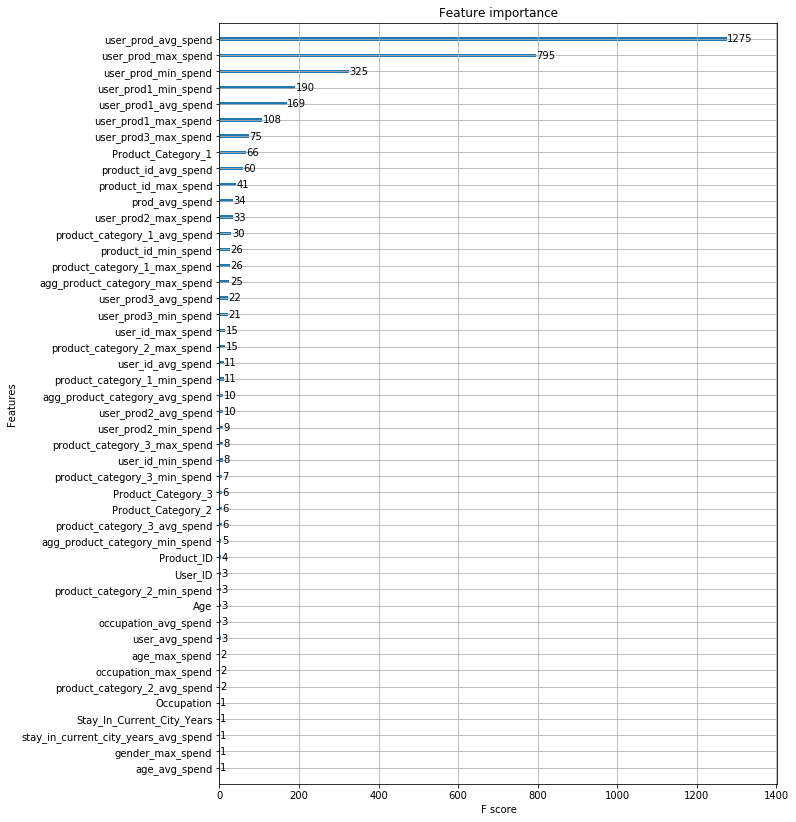

In [60]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))